In [63]:
# Import system modules
import sys
import os
sys.path.append('/Users/Volkan/Repos/somnotate-vlkuzun/src/somnotate_pipeline') # Adjust the path as necessary to your somnotate_pipeline directory

# Import required libraries for the pipeline
import numpy as np
import pandas as pd
import h5py
import pyedflib
import matplotlib.pyplot as plt

# Import functions from pipeline modules
from mat_to_csv import mat_to_csv
from make_path_sheet import make_train_and_test_sheet
from preprocess_signals import preprocess, main as preprocess_main  # Import preprocess and main

# Import necessary components for preprocessing
from lspopt import spectrogram_lspopt
from functools import partial
get_spectrogram = partial(spectrogram_lspopt, c_parameter=20.)

# Import utility functions from somnotate
from somnotate._utils import robust_normalize

# Somnotate Pipeline Notebook

This notebook provides a streamlined interface for running the somnotate pipeline:
1. Convert MAT files to CSV format
2. Generate EDF and Visbrain format files for visualization and analysis
3. Generate path sheet for organizing files
4. Preprocess signals for sleep stage analysis

Run each section in sequence, providing the requested inputs when prompted.

# Common Input Parameters

To make the workflow more efficient, we'll collect all common input parameters at the beginning and use them throughout the notebook.

In [53]:
# Collect common input parameters that will be reused throughout the notebook
# -----------------------------------------------------------------------------------
print("Enter the common parameters that will be used throughout the pipeline:")
print("-"*70)

# Dataset type
dataset_type = input("Enter dataset type ('train', 'test', or 'to_score'): ")

# Base directory
base_directory = input(f"Enter the base somnotate directory path, without quotes (e.g., Z:/somnotate): ")

# Sampling rate
sampling_rate = float(input("Enter the sampling rate in Hz (e.g., 512.0): "))

# Sleep stage resolution
sleep_stage_resolution = int(input("Enter the sleep stage resolution in seconds (e.g., 10): "))

# Mouse, session, recording information
print("\nEnter subject and recording information (format: comma-separated values without spaces)")
mouse_ids = input("Enter mouse IDs (e.g., sub-001,sub-002): ").split(',')
sessions = input("Enter session IDs (e.g., ses-01,ses-02): ").split(',')
recordings = input("Enter recording IDs (e.g., recording-01,recording-02): ").split(',')
extra_info = input("Enter any extra details about the recording (leave blank if not applicable): ").strip()

# Define derived paths for reuse
output_directory_path = os.path.join(base_directory, f"{dataset_type}_set", f"{dataset_type}_csv_files")
path_sheet_path = os.path.join(base_directory, f"{dataset_type}_set", f"{dataset_type}_sheet.csv")

# Print summary of all inputs
print("\nInput Summary:")
print(f"Dataset type: {dataset_type}")
print(f"Base directory: {base_directory}")
print(f"Sampling rate: {sampling_rate} Hz")
print(f"Sleep stage resolution: {sleep_stage_resolution} seconds")
print(f"Mouse IDs: {', '.join(mouse_ids)}")
print(f"Session IDs: {', '.join(sessions)}")
print(f"Recording IDs: {', '.join(recordings)}")
print(f"Extra info: {extra_info if extra_info else 'None'}")
print(f"CSV output directory: {output_directory_path}")
print(f"Path sheet location: {path_sheet_path}")

Enter the common parameters that will be used throughout the pipeline:
----------------------------------------------------------------------

Enter subject and recording information (format: comma-separated values without spaces)

Enter subject and recording information (format: comma-separated values without spaces)

Input Summary:
Dataset type: to_score
Base directory: /Volumes/harris/volkan/somnotate-vlkuzun-testing
Sampling rate: 512.0 Hz
Sleep stage resolution: 10 seconds
Mouse IDs: sub-015
Session IDs: ses-01
Recording IDs: recording-01
Extra info: time-0-20h
CSV output directory: /Volumes/harris/volkan/somnotate-vlkuzun-testing/to_score_set/to_score_csv_files
Path sheet location: /Volumes/harris/volkan/somnotate-vlkuzun-testing/to_score_set/to_score_sheet.csv

Input Summary:
Dataset type: to_score
Base directory: /Volumes/harris/volkan/somnotate-vlkuzun-testing
Sampling rate: 512.0 Hz
Sleep stage resolution: 10 seconds
Mouse IDs: sub-015
Session IDs: ses-01
Recording IDs: recor

In [ ]:
# Implementation of the generate_edf_and_visbrain_formats function directly in the notebook
def generate_edf_and_visbrain_formats(mouse_ids, sessions, recordings, extra_info, test_train_or_to_score, base_directory, sample_frequency):
    '''
    Generate EDF and Visbrain stage duration format files from CSV files, respectively for EEG and EMG data and sleep stage annotations.
    
    Inputs:
    mouse_ids: list of str, mouse IDs
    sessions: list of str, session IDs
    recordings: list of str, recording IDs
    extra_info: str, additional information to include in the output filenames for differentiation (optional)
    test_train_or_to_score: str, 'test', 'train' or 'to_score' to specify which dataset to process
    base_directory: str, path to the base directory where the CSV files are stored and where the output EDF and annotations files should be saved
    sample_frequency: float, the sampling frequency in Hz for the data

    Outputs:
    EDF files and annotations in Visbrain stage duration format are saved in the 'edfs' and '{test_train_or_to_score}_manual_annotation' directories, respectively.
    '''

    # Define output directories
    csv_input_dir = os.path.join(base_directory, f"{test_train_or_to_score}_set/{test_train_or_to_score}_csv_files")
    edf_output_dir = os.path.join(base_directory, f"{test_train_or_to_score}_set", 'edfs')
    annotations_output_dir = os.path.join(base_directory, f"{test_train_or_to_score}_set", f"{test_train_or_to_score}_manual_annotation")
    
    if not os.path.exists(edf_output_dir):
        os.makedirs(edf_output_dir)
    if not os.path.exists(annotations_output_dir):
        os.makedirs(annotations_output_dir)

    # Process each CSV file and generate output
    for mouse_id in mouse_ids:
        for session in sessions:
            for recording in recordings:
                # Prepare the base filename for the CSV file
                base_filename = f"{mouse_id}_{session}_{recording}"
                if extra_info:
                    csv_file = os.path.join(csv_input_dir, f"{base_filename}_{extra_info}.csv")
                else:
                    csv_file = os.path.join(csv_input_dir, f"{base_filename}.csv")
                
                # Prepare the base filename for EDF and Visbrain files
                if extra_info:
                    edf_file = os.path.join(edf_output_dir, f"output_{base_filename}_{extra_info}.edf")
                    visbrain_file = os.path.join(annotations_output_dir, f"annotations_visbrain_{base_filename}_{extra_info}.txt")
                else:
                    edf_file = os.path.join(edf_output_dir, f"output_{base_filename}.edf")
                    visbrain_file = os.path.join(annotations_output_dir, f"annotations_visbrain_{base_filename}.txt")

                if not os.path.isfile(csv_file):
                    print(f"File not found: {csv_file}")
                    continue
                if os.path.exists(edf_file):
                    print(f"EDF file already exists: {edf_file}")
                    continue
            
                print(f"Processing file: {csv_file}")
                df = pd.read_csv(csv_file)

                # Extract EEG and EMG data
                eeg1_data = df["EEG1"].to_numpy()
                eeg2_data = df["EEG2"].to_numpy()
                emg_data = df["EMG"].to_numpy()

                # Combine all data
                all_data = np.array([eeg1_data, eeg2_data, emg_data])

                # Create an EDF file
                f = pyedflib.EdfWriter(edf_file, len(all_data), file_type=pyedflib.FILETYPE_EDFPLUS)

                # Define EDF header information
                labels = ["EEG1", "EEG2", "EMG"]
                for i, label in enumerate(labels):
                    signal_info = {
                        'label': label,
                        'dimension': 'uV',
                        'sample_frequency': sample_frequency,
                        'physical_min': np.min(all_data[i]),
                        'physical_max': np.max(all_data[i]),
                        'digital_min': -32768,
                        'digital_max': 32767,
                        'transducer': '',
                        'prefilter': ''
                    }
                    f.setSignalHeader(i, signal_info)

                # Write EEG and EMG data to the EDF file
                f.writeSamples(all_data)
                f.close()

                # Prepare annotations in Visbrain stage duration format
                annotations = [(0, 10, "Undefined")]
                current_stage = None
                start_time = 10 / sample_frequency

                for i, label in enumerate(df["sleepStage"]):
                    current_time = i / sample_frequency
                    if label != current_stage:
                        if current_stage is not None:
                            annotations.append((start_time, current_time, current_stage))
                        current_stage = label
                        start_time = current_time
                annotations.append((start_time, len(df) / sample_frequency, current_stage))

                # Write annotations to a text file
                last_time_value = annotations[-1][1]
                with open(visbrain_file, "w") as f:
                    f.write(f"*Duration_sec    {last_time_value}\n")
                    f.write("*Datafile\tUnspecified\n")
                    for start, end, stage in annotations:
                        stage_label = {1: "awake", 2: "non-REM", 3: "REM", 4: 'ambiguous', 5: 'doubt'}.get(stage, "Undefined")
                        f.write(f"{stage_label}    {end}\n")

                print(f"EDF file and annotations created successfully for {mouse_id}, {session}, {recording} with extra info '{extra_info}'.")

# MAT to CSV Conversion

The first step in the pipeline is to convert MAT files (MATLAB format) to CSV format for easier manipulation in Python.

In [64]:
# STEP 1: MAT to CSV Conversion
# ---------------------------
print("STEP 1: MAT to CSV Conversion")
print("-----------------------------")

# We'll use the input parameters collected at the beginning
print(f"Using dataset type: {dataset_type}")
print(f"Using output directory: {output_directory_path}")
print(f"Using sampling rate: {sampling_rate} Hz")
print(f"Using sleep stage resolution: {sleep_stage_resolution} seconds")

# Allow user to enter file paths one by one
file_paths = []
print("\nEnter the full paths of .mat files to convert (press Enter on an empty line to finish):")
while True:
    file_path = input("Enter file path: ")
    if file_path == "":
        break
    if os.path.isfile(file_path) and file_path.endswith('.mat'):
        file_paths.append(file_path)
    else:
        print("Invalid file path. Please enter a valid .mat file path.")

# Print summary of files to process
print(f"\nFiles to process: {len(file_paths)}")
for i, path in enumerate(file_paths):
    print(f"  {i+1}. {path}")

# Confirm before proceeding
proceed = input("\nProceed with MAT to CSV conversion? (y/n): ").strip().lower()

STEP 1: MAT to CSV Conversion
-----------------------------
Using dataset type: to_score
Using output directory: /Volumes/harris/volkan/somnotate-vlkuzun-testing/to_score_set/to_score_csv_files
Using sampling rate: 512.0 Hz
Using sleep stage resolution: 10 seconds

Enter the full paths of .mat files to convert (press Enter on an empty line to finish):

Files to process: 1
  1. /Volumes/harris/volkan/somnotate-vlkuzun-testing/to_score_set/to_score_mat_files/sub-015_ses-01_recording-01_time-0-20h.mat

Files to process: 1
  1. /Volumes/harris/volkan/somnotate-vlkuzun-testing/to_score_set/to_score_mat_files/sub-015_ses-01_recording-01_time-0-20h.mat


In [65]:
# Execute the MAT to CSV conversion if inputs are valid
if proceed == 'y' and file_paths and output_directory_path:
    try:
        print("Starting MAT to CSV conversion process...")
        
        # Create the output directory if it doesn't exist
        if not os.path.exists(output_directory_path):
            os.makedirs(output_directory_path)
            print(f"Created output directory: {output_directory_path}")
        
        # Execute the conversion
        mat_to_csv(file_paths, output_directory_path, sampling_rate, sleep_stage_resolution)
        
        print("\nMAT to CSV conversion completed successfully!")
        print(f"CSV files are saved to: {output_directory_path}")
        
        # List the created output files
        output_files = [f for f in os.listdir(output_directory_path) if f.endswith('.csv')]
        print(f"\nCreated {len(output_files)} CSV files:")
        for i, file in enumerate(output_files):
            print(f"  {i+1}. {file}")
    
    except Exception as e:
        print(f"Error during conversion: {str(e)}")
else:
    print("MAT to CSV conversion cancelled or missing required inputs.")

Starting MAT to CSV conversion process...
Processing file: /Volumes/harris/volkan/somnotate-vlkuzun-testing/to_score_set/to_score_mat_files/sub-015_ses-01_recording-01_time-0-20h.mat
EEG1 data extracted successfully.
EEG2 data extracted successfully.
EMG data extracted successfully.
Length of upsampled sleep stages (5120) does not match length of EEG data (37319680)
EEG1 data extracted successfully.
EEG2 data extracted successfully.
EMG data extracted successfully.
Length of upsampled sleep stages (5120) does not match length of EEG data (37319680)
Saved CSV to: /Volumes/harris/volkan/somnotate-vlkuzun-testing/to_score_set/to_score_csv_files/sub-015_ses-01_recording-01_time-0-20h.csv

MAT to CSV conversion completed successfully!
CSV files are saved to: /Volumes/harris/volkan/somnotate-vlkuzun-testing/to_score_set/to_score_csv_files

Created 1 CSV files:
  1. sub-015_ses-01_recording-01_time-0-20h.csv
Saved CSV to: /Volumes/harris/volkan/somnotate-vlkuzun-testing/to_score_set/to_score_

# EDF and Visbrain Format Generation

After converting MAT files to CSV, the next step is to generate EDF files for the EEG/EMG data and Visbrain format files for the sleep stage annotations. This allows for visualization and further analysis of the data.

In [48]:
# STEP 2: Generate EDF and Visbrain Format Files
# ----------------------------------------------
print("STEP 2: Generate EDF and Visbrain Format Files")
print("-----------------------------------------")

# Use the parameters collected at the beginning
print(f"Using dataset type: {dataset_type}")
print(f"Using base directory: {base_directory}")
print(f"Using sampling rate: {sampling_rate} Hz")
print(f"Using mouse IDs: {', '.join(mouse_ids)}")
print(f"Using session IDs: {', '.join(sessions)}")
print(f"Using recording IDs: {', '.join(recordings)}")
print(f"Using extra info: {extra_info if extra_info else 'None'}")

# Calculate expected output paths for verification
edf_output_dir = os.path.join(base_directory, f"{dataset_type}_set", 'edfs')
annotations_output_dir = os.path.join(base_directory, f"{dataset_type}_set", f"{dataset_type}_manual_annotation")

print(f"\nEDF files will be saved to: {edf_output_dir}")
print(f"Annotation files will be saved to: {annotations_output_dir}")

# Confirm before proceeding
proceed = input("\nProceed with EDF and Visbrain format generation? (y/n): ").strip().lower()

STEP 2: Generate EDF and Visbrain Format Files
-----------------------------------------
Using dataset type: to_score
Using base directory: /Volumes/harris/volkan/somnotate-vlkuzun-testing
Using sampling rate: 512.0 Hz
Using mouse IDs: sub-015
Using session IDs: ses-01
Using recording IDs: recording-01
Using extra info: time-0-20h

EDF files will be saved to: /Volumes/harris/volkan/somnotate-vlkuzun-testing/to_score_set/edfs
Annotation files will be saved to: /Volumes/harris/volkan/somnotate-vlkuzun-testing/to_score_set/to_score_manual_annotation


In [ ]:
# Execute the EDF and Visbrain format generation
if proceed == 'y':
    try:
        print("Starting EDF and Visbrain format generation...")
        
        # Create directories if they don't exist
        if not os.path.exists(edf_output_dir):
            os.makedirs(edf_output_dir)
            print(f"Created directory: {edf_output_dir}")
            
        if not os.path.exists(annotations_output_dir):
            os.makedirs(annotations_output_dir)
            print(f"Created directory: {annotations_output_dir}")
            
        # Call the function defined in the notebook (keeping the local implementation)
        generate_edf_and_visbrain_formats(
            mouse_ids,
            sessions,
            recordings,
            extra_info,
            dataset_type,
            base_directory,
            sampling_rate
        )
        
        print("\nEDF and Visbrain format generation completed!")
        print(f"EDF files saved to: {edf_output_dir}")
        print(f"Visbrain annotations saved to: {annotations_output_dir}")
        
    except Exception as e:
        print(f"Error during EDF and Visbrain format generation: {str(e)}")
else:
    print("EDF and Visbrain format generation cancelled.")

Starting EDF and Visbrain format generation...
Processing file: /Volumes/harris/volkan/somnotate-vlkuzun-testing/to_score_set/to_score_csv_files/sub-015_ses-01_recording-01_time-0-20h.csv


/Users/Volkan/miniconda3/envs/somnotate-vlkuzun/lib/python3.11/site-packages/pyedflib/edfwriter.py:133: UserWarning: Physical minimum for channel 0 (EEG1) is -480.70989990234375, which has 19 chars, however, EDF+ can only save 8 chars, will be truncated to -480.709, some loss of precision is to be expected
  warnings.warn('Physical minimum for channel {} ({}) is {}, which has {} chars, '
/Users/Volkan/miniconda3/envs/somnotate-vlkuzun/lib/python3.11/site-packages/pyedflib/edfwriter.py:140: UserWarning: Physical maximum for channel 0 (EEG1) is 480.4759826660156, which has 17 chars, however, EDF+ can only save 8 chars, will be truncated to 480.4759, some loss of precision is to be expected.
  warnings.warn('Physical maximum for channel {} ({}) is {}, which has {} chars, '
/Users/Volkan/miniconda3/envs/somnotate-vlkuzun/lib/python3.11/site-packages/pyedflib/edfwriter.py:133: UserWarning: Physical minimum for channel 1 (EEG2) is -480.2402648925781, which has 18 chars, however, EDF+ can onl

EDF file and annotations created successfully for sub-015, ses-01, recording-01 with extra info 'time-0-20h'.

EDF and Visbrain format generation completed!
EDF files saved to: /Volumes/harris/volkan/somnotate-vlkuzun-testing/to_score_set/edfs
Visbrain annotations saved to: /Volumes/harris/volkan/somnotate-vlkuzun-testing/to_score_set/to_score_manual_annotation


# Path Sheet Generation

After generating the EDF and Visbrain format files, the next step is to create a path sheet. This CSV file organizes all your data file paths in one place, making it easier to manage and access the different components of your dataset.

In [50]:
# STEP 3: Generate Path Sheet
# ---------------------------
print("STEP 3: Generate Path Sheet")
print("---------------------------")

# Use the parameters collected at the beginning
print(f"Using dataset type: {dataset_type}")
print(f"Using base directory: {base_directory}")
print(f"Using sampling rate: {sampling_rate} Hz")

# Show the expected path sheet output location
expected_output_path = os.path.join(base_directory, f"{dataset_type}_set", f"{dataset_type}_sheet.csv")
print(f"\nThe path sheet will be saved to: {expected_output_path}")

# Confirm before proceeding
proceed = input("\nProceed with path sheet generation? (y/n): ").strip().lower()

if proceed == 'y':
    try:
        print("Starting path sheet generation...")
        
        # Generate the path sheet using the imported function
        output_file = make_train_and_test_sheet(dataset_type, base_directory, sampling_rate)
        
        print("\nPath sheet generation completed!")
        print(f"Path sheet saved to: {expected_output_path}")
    
    except Exception as e:
        print(f"Error during path sheet generation: {str(e)}")
else:
    print("Path sheet generation cancelled.")

STEP 3: Generate Path Sheet
---------------------------
Using dataset type: to_score
Using base directory: /Volumes/harris/volkan/somnotate-vlkuzun-testing
Using sampling rate: 512.0 Hz

The path sheet will be saved to: /Volumes/harris/volkan/somnotate-vlkuzun-testing/to_score_set/to_score_sheet.csv
Starting path sheet generation...
Including ['/Volumes/harris/volkan/somnotate-vlkuzun-testing/to_score_set/to_score_manual_annotation/annotations_visbrain_sub-015_ses-01_recording-01_time-0-20h.txt'] in the to_score set.
Including ['/Volumes/harris/volkan/somnotate-vlkuzun-testing/to_score_set/edfs/output_sub-015_ses-01_recording-01_time-0-20h.edf'] in the to_score set.
output_sub-015_ses-01_recording-01_time-0-20h

Path sheet generation completed!
Path sheet saved to: /Volumes/harris/volkan/somnotate-vlkuzun-testing/to_score_set/to_score_sheet.csv
Starting path sheet generation...
Including ['/Volumes/harris/volkan/somnotate-vlkuzun-testing/to_score_set/to_score_manual_annotation/annotati

# Signal Preprocessing

After generating the path sheet, we can use it to preprocess the EDF signals by computing spectrograms. This step extracts features needed for machine learning models to classify sleep stages.

In [58]:
# STEP 4: Preprocess Signals
# --------------------------
print("STEP 4: Preprocess Signals")
print("--------------------------")

# Use the path sheet generated in the previous step
print(f"Using path sheet: {path_sheet_path}")

# Ask if user wants to see plots
show_plots = input("\nDo you want to generate plots of the preprocessed signals? (y/n): ").strip().lower() == 'y'

# Confirm before proceeding
proceed = input("\nProceed with signal preprocessing? (y/n): ").strip().lower()

if proceed == 'y':
    try:
        if os.path.exists(path_sheet_path):
            print("Starting signal preprocessing...")
            
            # Import needed functions and modules for preprocessing
            from data_io import load_dataframe, check_dataframe, load_raw_signals, export_preprocessed_signals
            import matplotlib.pyplot as plt
            
            # Load the path sheet
            datasets = load_dataframe(path_sheet_path)
            print(f"Loaded {len(datasets)} dataset(s) from {path_sheet_path}")
            
            # Check required columns
            required_columns = ['file_path_raw_signals', 'sampling_frequency_in_hz', 'file_path_preprocessed_signals',
                              'eeg1_signal_label', 'eeg2_signal_label', 'emg_signal_label']
            check_dataframe(datasets, columns=required_columns)
            
            # Define commonly used signal labels
            state_annotation_signals = ['eeg1_signal_label', 'eeg2_signal_label', 'emg_signal_label']
            
            # Set preprocessing parameters
            time_resolution = 1  # Default time resolution in seconds
            
            # Create output directory for plots if showing them
            if show_plots:
                output_folder = os.path.join(os.path.dirname(path_sheet_path), 'output_figures')
                os.makedirs(output_folder, exist_ok=True)
                print(f"Created directory for figures: {output_folder}")
            
            # Define a function to plot raw signals (usually imported from somewhere else)
            def plot_raw_signals(raw_signals, sampling_frequency, ax):
                time = np.arange(len(raw_signals)) / sampling_frequency
                for i in range(raw_signals.shape[1]):
                    ax.plot(time, raw_signals[:, i], label=f"Channel {i+1}")
                ax.set_ylabel('Amplitude')
                ax.legend()
                return ax
            
            # Process each dataset in the path sheet
            for ii, (idx, dataset) in enumerate(datasets.iterrows()):
                print(f"\nProcessing {ii+1}/{len(datasets)}: {os.path.basename(dataset['file_path_raw_signals'])}")
                
                # Determine EDF signals to load
                signal_labels = [dataset[column_name] for column_name in state_annotation_signals]
                
                # Load data
                raw_signals = load_raw_signals(dataset['file_path_raw_signals'], signal_labels)
                
                preprocessed_signals = []
                for signal in raw_signals.T:
                    # Fix: Convert time_resolution_in_sec * sampling_frequency to integer for nperseg
                    nperseg = int(time_resolution * dataset['sampling_frequency_in_hz'])
                    
                    # Modified preprocess function call with explicit nperseg parameter
                    frequencies, time, spectrogram = get_spectrogram(
                        signal,
                        fs=dataset['sampling_frequency_in_hz'],
                        nperseg=nperseg,  # Make sure this is an integer
                        noverlap=0
                    )
                    
                    # Process the spectrogram as in the original preprocess function
                    # Filter frequency bands
                    low_cut = 1.0
                    high_cut = 90.0
                    notch_low_cut = 45.0
                    notch_high_cut = 55.0
                    
                    # exclude ill-determined frequencies
                    mask = (frequencies >= low_cut) & (frequencies < high_cut)
                    frequencies = frequencies[mask]
                    spectrogram = spectrogram[mask]

                    # exclude noise-contaminated frequencies around 50 Hz
                    mask = (frequencies >= notch_low_cut) & (frequencies <= notch_high_cut)
                    frequencies = frequencies[~mask]
                    spectrogram = spectrogram[~mask]

                    # Log transform and normalize
                    spectrogram = np.log(spectrogram + 1)
                    spectrogram = robust_normalize(spectrogram, p=5., axis=1, method='standard score')
                    
                    preprocessed_signals.append(spectrogram)
                
                # Show input and outputs for quality control
                if show_plots:
                    fig, axes = plt.subplots(1+len(preprocessed_signals), 1, figsize=(12, 8), sharex=True)
                    
                    # Plot raw signals
                    plot_raw_signals(
                        raw_signals,
                        sampling_frequency=dataset['sampling_frequency_in_hz'],
                        ax=axes[0] if isinstance(axes, np.ndarray) else axes
                    )
                    
                    # Plot spectrograms
                    for i, signal in enumerate(preprocessed_signals):
                        if isinstance(axes, np.ndarray):
                            ax = axes[i+1]
                        else:
                            fig_new, ax = plt.subplots(figsize=(12, 4))
                        
                        im = ax.imshow(signal, 
                                      aspect='auto', 
                                      origin='lower', 
                                      extent=[time[0], time[-1], frequencies[0], frequencies[-1]],
                                      cmap='viridis')
                        ax.set_ylabel('Frequency (Hz)')
                        plt.colorbar(im, ax=ax, label='Power (normalized)')
                    
                    # Set common labels
                    if isinstance(axes, np.ndarray):
                        axes[-1].set_xlabel('Time (s)')
                    else:
                        axes.set_xlabel('Time (s)')
                    
                    # Save figure
                    plt.tight_layout()
                    fig_path = os.path.join(output_folder, f'preprocessed_signals_{ii}.png')
                    plt.savefig(fig_path)
                    plt.close(fig)
                    print(f"  Saved figure to {fig_path}")
                
                # Concatenate spectrograms and save
                preprocessed_signals = np.concatenate([signal.T for signal in preprocessed_signals], axis=1)
                export_preprocessed_signals(dataset['file_path_preprocessed_signals'], preprocessed_signals)
                print(f"  Saved preprocessed signals to {dataset['file_path_preprocessed_signals']}")
            
            print("\nPreprocessing completed!")
            
            # Inform the user where to find the output
            preprocessed_dir = os.path.join(base_directory, f"{dataset_type}_set", "preprocessed_signals")
            figures_dir = os.path.join(base_directory, f"{dataset_type}_set", "output_figures")
            print(f"Preprocessed signals are saved to: {preprocessed_dir}")
            if show_plots:
                print(f"Visualization plots are saved to: {figures_dir}")
        else:
            print(f"Error: Path sheet not found at {path_sheet_path}")
            print("Please run the path sheet generation step first.")
    
    except Exception as e:
        print(f"Error during signal preprocessing: {str(e)}")
        import traceback
        traceback.print_exc()  # Print the full traceback for better debugging
else:
    print("Signal preprocessing cancelled.")

STEP 4: Preprocess Signals
--------------------------
Using path sheet: /Volumes/harris/volkan/somnotate-vlkuzun-testing/to_score_set/to_score_sheet.csv
Starting signal preprocessing...
Loaded 1 dataset(s) from /Volumes/harris/volkan/somnotate-vlkuzun-testing/to_score_set/to_score_sheet.csv

Processing 1/1: output_sub-015_ses-01_recording-01_time-0-20h.edf
Starting signal preprocessing...
Loaded 1 dataset(s) from /Volumes/harris/volkan/somnotate-vlkuzun-testing/to_score_set/to_score_sheet.csv

Processing 1/1: output_sub-015_ses-01_recording-01_time-0-20h.edf
  Saved preprocessed signals to /Volumes/harris/volkan/somnotate-vlkuzun-testing/to_score_set/preprocessed_signals/output_sub-015_ses-01_recording-01_time-0-20h.npy

Preprocessing completed!
Preprocessed signals are saved to: /Volumes/harris/volkan/somnotate-vlkuzun-testing/to_score_set/preprocessed_signals
  Saved preprocessed signals to /Volumes/harris/volkan/somnotate-vlkuzun-testing/to_score_set/preprocessed_signals/output_sub-

# Pipeline Summary

If all steps completed successfully, you should now have:

1. CSV files containing the extracted data from your MAT files
2. EDF files containing the EEG and EMG signal data for visualization
3. Visbrain format annotation files for sleep stage analysis
4. A path sheet CSV file organizing all your data file paths
5. Preprocessed signal spectrograms for machine learning analysis

These outputs can be used for sleep stage classification and further analysis using the somnotate toolchain.

# Automated Sleep Stage Annotation

After preprocessing the signals, we can use a pre-trained model to automatically annotate sleep stages. This step:
1. Takes the preprocessed signals (spectrograms) as input
2. Uses a machine learning model to predict sleep stages
3. Outputs the predicted hypnogram 
4. Identifies regions that may need manual review (low confidence predictions)

In [59]:
# STEP 5: Automated Sleep Stage Annotation
# ---------------------------------------
print("STEP 5: Automated Sleep Stage Annotation")
print("---------------------------------------")

# Use the path sheet generated previously
print(f"Using path sheet: {path_sheet_path}")

# Ask for the trained model file path
model_path = input("\nEnter the path to the trained model (.pickle file): ")

# Ask if user wants to see plots
show_plots = input("\nDo you want to generate plots of the annotations? (y/n): ").strip().lower() == 'y'

# Confirm before proceeding
proceed = input("\nProceed with sleep stage annotation? (y/n): ").strip().lower()

if proceed == 'y':
    try:
        if os.path.exists(path_sheet_path):
            if not os.path.exists(model_path):
                print(f"Error: Model file not found at {model_path}")
            else:
                print("Starting automated sleep stage annotation...")
                
                # Import necessary components
                from somnotate._automated_state_annotation import StateAnnotator
                from somnotate._utils import convert_state_vector_to_state_intervals, _get_intervals
                from data_io import load_dataframe, check_dataframe, load_preprocessed_signals, load_raw_signals, export_hypnogram, export_review_intervals
                
                # Load the path sheet
                datasets = load_dataframe(path_sheet_path)
                print(f"Loaded {len(datasets)} dataset(s) from {path_sheet_path}")
                
                # Check required columns
                required_columns = [
                    'file_path_preprocessed_signals', 
                    'file_path_automated_state_annotation', 
                    'file_path_review_intervals'
                ]
                if show_plots:
                    required_columns.extend(['file_path_raw_signals', 'sampling_frequency_in_hz'])
                    required_columns.extend(['eeg1_signal_label', 'eeg2_signal_label', 'emg_signal_label'])
                    
                check_dataframe(datasets, columns=required_columns)
                
                # Helper function to export intervals for manual review
                def export_intervals_with_low_confidence(file_path, state_probability, threshold=0.99, time_resolution=1):
                    intervals = _get_intervals(state_probability < threshold)
                    scores = [len(state_probability[start:stop]) - np.sum(state_probability[start:stop]) 
                              for start, stop in intervals]
                    intervals = [(start * time_resolution, stop * time_resolution) for start, stop in intervals]
                    notes = ['probability below threshold' for _ in intervals]
                    export_review_intervals(file_path, intervals, scores, notes)
                
                # Define state mappings
                int_to_state = {
                    1: "awake",
                    2: "non-REM",
                    3: "REM",
                    4: "ambiguous",
                    5: "doubt"
                }
                
                # Time resolution in seconds
                time_resolution = 1
                
                # Load the trained model
                print(f"Loading trained model from {model_path}...")
                annotator = StateAnnotator()
                annotator.load(model_path)
                
                # Process each dataset
                for ii, (idx, dataset) in enumerate(datasets.iterrows()):
                    print(f"\nProcessing {ii+1}/{len(datasets)}: {os.path.basename(dataset['file_path_preprocessed_signals'])}")
                    
                    # Load preprocessed signals
                    try:
                        signal_array = load_preprocessed_signals(dataset['file_path_preprocessed_signals'])
                    except Exception as e:
                        print(f"  Error loading preprocessed signals: {e}")
                        continue
                    
                    # Create output directories if needed
                    for path_key in ['file_path_automated_state_annotation', 'file_path_review_intervals']:
                        directory = os.path.dirname(dataset[path_key])
                        if not os.path.exists(directory):
                            os.makedirs(directory, exist_ok=True)
                    
                    # Predict states and probabilities
                    print("  Annotating sleep states...")
                    predicted_state_vector = annotator.predict(signal_array)
                    state_probability = annotator.predict_proba(signal_array)
                    
                    # Convert to intervals and export
                    predicted_states, predicted_intervals = convert_state_vector_to_state_intervals(
                        predicted_state_vector, 
                        mapping=int_to_state, 
                        time_resolution=time_resolution
                    )
                    
                    # Export hypnogram and review intervals
                    export_hypnogram(dataset['file_path_automated_state_annotation'], 
                                     predicted_states, 
                                     predicted_intervals)
                    print(f"  Saved hypnogram to {dataset['file_path_automated_state_annotation']}")
                    
                    export_intervals_with_low_confidence(
                        dataset['file_path_review_intervals'],
                        state_probability,
                        threshold=0.99,
                        time_resolution=time_resolution
                    )
                    print(f"  Saved review intervals to {dataset['file_path_review_intervals']}")
                    
                    # Generate visualization if requested
                    if show_plots:
                        print("  Generating visualization...")
                        fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
                        
                        # Plot raw signals
                        signal_labels = [dataset[col] for col in ['eeg1_signal_label', 'eeg2_signal_label', 'emg_signal_label']]
                        raw_signals = load_raw_signals(dataset['file_path_raw_signals'], signal_labels)
                        
                        # Time array for raw signals
                        time_raw = np.arange(len(raw_signals)) / dataset['sampling_frequency_in_hz']
                        
                        # Plot raw signals
                        for i, (signal, label) in enumerate(zip(raw_signals.T, signal_labels)):
                            axes[0].plot(time_raw, signal, label=label)
                        axes[0].set_title('Raw Signals')
                        axes[0].set_ylabel('Amplitude')
                        axes[0].legend()
                        
                        # Plot prediction probabilities
                        time_prob = np.arange(len(state_probability)) * time_resolution
                        axes[1].plot(time_prob, state_probability)
                        axes[1].set_title('Prediction Confidence')
                        axes[1].set_ylabel('Confidence')
                        axes[1].axhline(y=0.99, color='r', linestyle='--', label='Threshold')
                        axes[1].legend()
                        
                        # Plot predicted states
                        yticklabels = list(int_to_state.values())
                        yticks = list(range(1, len(yticklabels) + 1))
                        
                        # Convert states to numeric for plotting
                        state_nums = []
                        for state in predicted_states:
                            for num, label in int_to_state.items():
                                if state == label:
                                    state_nums.append(num)
                                    break
                        
                        for i, (state, (start, end)) in enumerate(zip(state_nums, predicted_intervals)):
                            axes[2].fill_between([start, end], [state, state], [state-0.9, state-0.9], alpha=0.7)
                        
                        axes[2].set_yticks(yticks)
                        axes[2].set_yticklabels(yticklabels)
                        axes[2].set_title('Predicted Sleep Stages')
                        axes[2].set_ylabel('State')
                        axes[2].set_xlabel('Time (s)')
                        
                        plt.tight_layout()
                        
                        # Save figure
                        output_folder = os.path.join(os.path.dirname(path_sheet_path), 'output_figures')
                        os.makedirs(output_folder, exist_ok=True)
                        fig_path = os.path.join(output_folder, f'annotation_{ii}.png')
                        plt.savefig(fig_path)
                        plt.close(fig)
                        print(f"  Saved figure to {fig_path}")
                
                print("\nSleep stage annotation completed!")
                
                # Inform the user where to find the output
                annotations_dir = os.path.join(base_directory, f"{dataset_type}_set", "automated_annotation")
                review_dir = os.path.join(base_directory, f"{dataset_type}_set", "int")
                figures_dir = os.path.join(base_directory, f"{dataset_type}_set", "output_figures")
                print(f"Automated annotations are saved to: {annotations_dir}")
                print(f"Review intervals are saved to: {review_dir}")
                if show_plots:
                    print(f"Visualization plots are saved to: {figures_dir}")
        else:
            print(f"Error: Path sheet not found at {path_sheet_path}")
            print("Please run the path sheet generation step first.")
    
    except Exception as e:
        print(f"Error during sleep stage annotation: {str(e)}")
        import traceback
        traceback.print_exc()  # Print the full traceback for better debugging
else:
    print("Sleep stage annotation cancelled.")

STEP 5: Automated Sleep Stage Annotation
---------------------------------------
Using path sheet: /Volumes/harris/volkan/somnotate-vlkuzun-testing/to_score_set/to_score_sheet.csv
Starting automated sleep stage annotation...
Loaded 1 dataset(s) from /Volumes/harris/volkan/somnotate-vlkuzun-testing/to_score_set/to_score_sheet.csv
Loading trained model from /Volumes/harris/volkan/somnotate-vlkuzun-testing/ws_model.pickle...


/Users/Volkan/miniconda3/envs/somnotate-vlkuzun/lib/python3.11/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LinearDiscriminantAnalysis from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(



Processing 1/1: output_sub-015_ses-01_recording-01_time-0-20h.npy
  Annotating sleep states...
  Saved hypnogram to /Volumes/harris/volkan/somnotate-vlkuzun-testing/to_score_set/automated_annotation/automated_state_annotationoutput_sub-015_ses-01_recording-01_time-0-20h.txt
  Saved review intervals to /Volumes/harris/volkan/somnotate-vlkuzun-testing/to_score_set/int/review_intervalsoutput_sub-015_ses-01_recording-01_time-0-20h.txt

Sleep stage annotation completed!
Automated annotations are saved to: /Volumes/harris/volkan/somnotate-vlkuzun-testing/to_score_set/automated_annotation
Review intervals are saved to: /Volumes/harris/volkan/somnotate-vlkuzun-testing/to_score_set/int


# Manual Review and Refinement

After automated annotation, you may want to review and refine the results, especially in regions with low confidence predictions. Use the Visbrain interface or another annotation tool to:

1. Open the EDF files with raw signals
2. Load the automated annotations
3. Review the suggested intervals
4. Make manual corrections
5. Save the refined annotations

This step is performed outside of this notebook using specialized annotation software.

STEP 6: Calculate Sleep State Proportions
---------------------------------------

This function analyzes the proportion of sleep states in a specified time window.
Total recording duration: 72890.00 seconds (1214.83 minutes)

Sleep State Analysis Results:
----------------------------------------
Analysis Window: 0.00 to 3600.00 seconds
Window Duration: 3600.00 seconds (60.00 minutes)

State Proportions:
     awake:  95.25% (3429.00 seconds)
   non-REM:   2.14% (77.00 seconds)
       REM:   2.61% (94.00 seconds)

Pie chart saved to /Volumes/harris/volkan/somnotate-vlkuzun-testing/to_score_set/automated_annotation/output_figures/sleep_proportions_0_3600.png


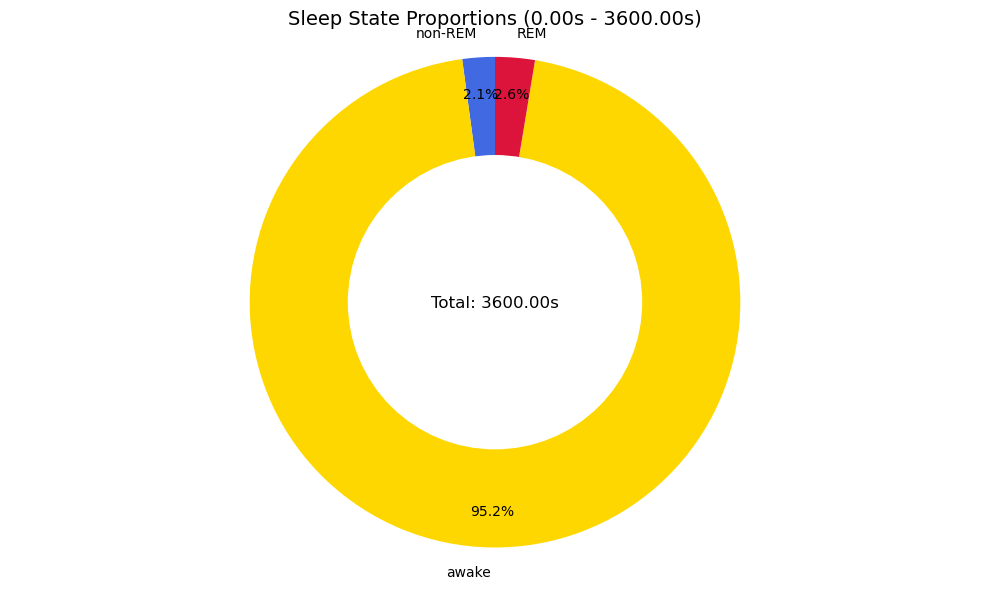

In [60]:
# STEP 6: Calculate Sleep State Proportions
# ---------------------------------------
print("STEP 6: Calculate Sleep State Proportions")
print("---------------------------------------")

def analyze_sleep_state_proportions(annotation_file, start_time_sec, end_time_sec):
    """
    Analyze the proportion of different sleep states within a specified time window.
    
    Parameters:
    -----------
    annotation_file : str
        Path to the annotation file in Visbrain format
    start_time_sec : float
        Start time of the analysis window in seconds
    end_time_sec : float
        End time of the analysis window in seconds
        
    Returns:
    --------
    dict
        Dictionary containing the proportion of each sleep state and total duration
    """
    # Read the annotation file
    with open(annotation_file, 'r') as f:
        lines = f.readlines()
    
    # Extract the duration from the header
    duration_line = lines[0].strip()
    if duration_line.startswith('*Duration_sec'):
        total_duration = float(duration_line.split()[1])
    else:
        raise ValueError("Invalid annotation file format: missing duration header")
    
    # Skip header lines
    data_lines = [line for line in lines if not line.startswith('*')]
    
    # Parse annotations
    end_times = []
    states = []
    for line in data_lines:
        parts = line.strip().split()
        if len(parts) >= 2:
            states.append(parts[0])
            end_times.append(float(parts[1]))
    
    # Calculate state intervals
    intervals = []
    start_times = [0] + end_times[:-1]
    for state, start, end in zip(states, start_times, end_times):
        intervals.append((state, start, end))
    
    # Filter intervals to the specified time window
    filtered_intervals = []
    for state, start, end in intervals:
        # Skip intervals outside the time window
        if end <= start_time_sec or start >= end_time_sec:
            continue
        
        # Clip interval to the time window
        clipped_start = max(start, start_time_sec)
        clipped_end = min(end, end_time_sec)
        filtered_intervals.append((state, clipped_start, clipped_end))
    
    # Calculate total duration of each state
    state_durations = {}
    for state, start, end in filtered_intervals:
        duration = end - start
        state_durations[state] = state_durations.get(state, 0) + duration
    
    # Calculate total window duration and proportions
    window_duration = end_time_sec - start_time_sec
    state_proportions = {state: duration / window_duration 
                        for state, duration in state_durations.items()}
    
    # Add total durations to results
    state_proportions['window_duration'] = window_duration
    for state, duration in state_durations.items():
        state_proportions[f'{state}_duration'] = duration
    
    return state_proportions

# Prompt for inputs
print("\nThis function analyzes the proportion of sleep states in a specified time window.")
annotation_file = input("Enter the path to the annotation file: ")

if os.path.exists(annotation_file):
    # Read the file to get the total duration
    with open(annotation_file, 'r') as f:
        first_line = f.readline().strip()
        if first_line.startswith('*Duration_sec'):
            total_duration = float(first_line.split()[1])
            print(f"Total recording duration: {total_duration:.2f} seconds ({total_duration/60:.2f} minutes)")
        else:
            print("Could not determine recording duration. Proceeding anyway.")
            total_duration = None
    
    try:
        start_time = float(input(f"Enter start time in seconds: "))
        end_time = float(input(f"Enter end time in seconds{f' (max {total_duration})' if total_duration else ''}: "))
        
        if total_duration and end_time > total_duration:
            print(f"Warning: End time exceeds recording duration. Setting to maximum ({total_duration})")
            end_time = total_duration
        
        if start_time >= end_time:
            print("Error: Start time must be less than end time.")
        else:
            # Calculate proportions
            results = analyze_sleep_state_proportions(annotation_file, start_time, end_time)
            
            # Display results
            print("\nSleep State Analysis Results:")
            print("-" * 40)
            print(f"Analysis Window: {start_time:.2f} to {end_time:.2f} seconds")
            print(f"Window Duration: {results['window_duration']:.2f} seconds ({results['window_duration']/60:.2f} minutes)")
            print("\nState Proportions:")
            
            # Create a nice table of results
            key_states = ['awake', 'non-REM', 'REM']
            for state in key_states:
                if state in results:
                    duration = results.get(f'{state}_duration', 0)
                    proportion = results.get(state, 0) * 100
                    print(f"{state:>10}: {proportion:6.2f}% ({duration:.2f} seconds)")
                else:
                    print(f"{state:>10}: 0.00% (0.00 seconds)")
            
            # Display info about other states if present
            other_states = [s for s in results.keys() 
                           if s not in key_states and 
                              not s.endswith('_duration') and 
                              s != 'window_duration']
            if other_states:
                print("\nOther States:")
                for state in other_states:
                    duration = results.get(f'{state}_duration', 0)
                    proportion = results.get(state, 0) * 100
                    print(f"{state:>10}: {proportion:6.2f}% ({duration:.2f} seconds)")
            
            # Visualize as a pie chart
            import matplotlib.pyplot as plt
            
            # Extract just the proportions for the pie chart
            labels = []
            sizes = []
            for state in results:
                if not state.endswith('_duration') and state != 'window_duration':
                    labels.append(state)
                    sizes.append(results[state])
            
            # Create custom colors for standard states
            colors = []
            for label in labels:
                if label == 'awake':
                    colors.append('gold')
                elif label == 'non-REM':
                    colors.append('royalblue')
                elif label == 'REM':
                    colors.append('crimson')
                else:
                    colors.append('gray')
            
            fig, ax = plt.subplots(figsize=(10, 6))
            wedges, texts, autotexts = ax.pie(
                sizes, 
                labels=labels,
                colors=colors,
                autopct='%1.1f%%',
                startangle=90,
                pctdistance=0.85
            )
            
            # Draw a white circle at the center to create a donut chart
            centre_circle = plt.Circle((0,0), 0.60, fc='white')
            fig.gca().add_artist(centre_circle)
            
            # Add title and annotation
            ax.set_title(f'Sleep State Proportions ({start_time:.2f}s - {end_time:.2f}s)', size=14)
            plt.text(0, 0, f"Total: {results['window_duration']:.2f}s", ha='center', va='center', fontsize=12)
            
            # Equal aspect ratio ensures that pie is drawn as a circle
            ax.axis('equal')
            plt.tight_layout()
            
            # Save the figure
            output_folder = os.path.join(os.path.dirname(annotation_file), 'output_figures')
            os.makedirs(output_folder, exist_ok=True)
            fig_path = os.path.join(output_folder, f'sleep_proportions_{start_time:.0f}_{end_time:.0f}.png')
            plt.savefig(fig_path)
            print(f"\nPie chart saved to {fig_path}")
            plt.show()
            
    except ValueError as e:
        print(f"Error with input values: {e}")
else:
    print(f"Error: Annotation file not found at {annotation_file}")

# Batch Processing Sleep State Proportions

If you need to analyze multiple time windows across one or more recordings, you can use the following function to process them in batch and save the results to a CSV file.

In [ ]:
# Batch processing for multiple time windows and recordings
# --------------------------------------------------------

def batch_analyze_sleep_proportions(file_list, time_windows, output_file=None):
    """
    Analyze sleep state proportions for multiple files and time windows.
    
    Parameters:
    -----------
    file_list : list of str
        List of paths to annotation files
    time_windows : list of tuples
        List of (start_time, end_time) tuples in seconds
    output_file : str, optional
        Path to save the results as CSV. If None, results are not saved.
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame containing the results
    """
    results = []
    
    for file_path in file_list:
        file_name = os.path.basename(file_path)
        
        for start_time, end_time in time_windows:
            try:
                # Skip invalid time windows
                if start_time >= end_time:
                    print(f"Skipping invalid time window: {start_time}-{end_time}")
                    continue
                
                print(f"Processing {file_name}: {start_time}s to {end_time}s")
                proportions = analyze_sleep_state_proportions(file_path, start_time, end_time)
                
                # Create a row for this result
                result_row = {
                    'file_name': file_name,
                    'start_time': start_time,
                    'end_time': end_time,
                    'window_duration': proportions['window_duration']
                }
                
                # Add proportions for each state
                for state, proportion in proportions.items():
                    if state not in ['window_duration'] and not state.endswith('_duration'):
                        result_row[f'{state}_proportion'] = proportion
                        result_row[f'{state}_duration'] = proportions.get(f'{state}_duration', 0)
                
                results.append(result_row)
                
            except Exception as e:
                print(f"Error processing {file_name}, window {start_time}-{end_time}: {str(e)}")
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Save to CSV if requested
    if output_file and len(results) > 0:
        results_df.to_csv(output_file, index=False)
        print(f"Results saved to {output_file}")
    
    return results_df

# Prompt for batch processing
print("\nBatch Processing of Sleep State Proportions")
print("------------------------------------------")
print("This function analyzes sleep state proportions across multiple files and time windows.")

proceed_batch = input("\nDo you want to perform batch processing? (y/n): ").strip().lower()

if proceed_batch == 'y':
    # Get annotation files
    annotation_files = []
    print("\nEnter the paths to annotation files (press Enter on an empty line to finish):")
    while True:
        file_path = input("Enter annotation file path: ")
        if file_path == "":
            break
        if os.path.isfile(file_path):
            annotation_files.append(file_path)
        else:
            print("Invalid file path. Please enter a valid file path.")
    
    if not annotation_files:
        print("No valid annotation files provided. Batch processing cancelled.")
    else:
        # Get time windows
        time_windows = []
        print("\nNow enter time windows (start and end times in seconds):")
        while True:
            try:
                start_input = input("Enter start time in seconds (or press Enter to finish): ")
                if start_input == "":
                    break
                    
                start_time = float(start_input)
                end_time = float(input("Enter end time in seconds: "))
                
                if start_time < end_time:
                    time_windows.append((start_time, end_time))
                else:
                    print("Error: Start time must be less than end time.")
            except ValueError:
                print("Invalid input. Please enter numeric values.")
        
        if not time_windows:
            print("No valid time windows provided. Batch processing cancelled.")
        else:
            # Get output file
            output_file = input("\nEnter path to save results CSV (or press Enter to skip saving): ")
            if output_file.strip() == "":
                output_file = None
            
            # Perform batch analysis
            print(f"\nProcessing {len(annotation_files)} files with {len(time_windows)} time windows...")
            results_df = batch_analyze_sleep_proportions(annotation_files, time_windows, output_file)
            
            # Display summary
            print("\nProcessing completed!")
            if not results_df.empty:
                print("\nSummary of Results:")
                print(results_df)
else:
    print("Batch processing cancelled.")

# Time Period Analysis Examples

Below are some common time periods that are often analyzed in sleep studies:

1. **Light Phase vs Dark Phase**
   - Mice are nocturnal, so their sleep patterns differ between light and dark periods.
   - Typically, the light phase corresponds to ZT0-ZT12 (hours 0-12) and dark phase to ZT12-ZT24 (hours 12-24).

2. **Early vs Late Light/Dark Phases**
   - Early light phase: ZT0-ZT6 (hours 0-6)
   - Late light phase: ZT6-ZT12 (hours 6-12) 
   - Early dark phase: ZT12-ZT18 (hours 12-18)
   - Late dark phase: ZT18-ZT24 (hours 18-24)

3. **Specific Time Windows After Interventions**
   - First hour after drug administration: Start time = administration time, End time = administration time + 3600 seconds
   - Recovery period after sleep deprivation: Start time = end of deprivation, End time = start time + desired recovery duration

Use the tools above to analyze these time periods and compare the results between experimental conditions.